In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
%matplotlib inline

### cifar10 데이터셋 다운로드

In [2]:
# 데이터 다운로드 하기
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

#tgz 파일 압축 풀기
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='.')

Using downloaded and verified file: ./cifar10.tgz


### 데이터 경로 및 디렉토리 구조 확인

In [3]:
data_dir = './cifar10'
print(f"'{data_dir}' 에는 {os.listdir(data_dir)} 디렉토리가 존재합니다.")
print("")
classes = os.listdir(data_dir + "/train")
print(f"train 디렉토리 안에는 \n {classes} \n 디렉토리가 존재하며, 각 디렉토리에는 레이블에 해당하는 이미지데이터가 존재 합니다.")
# '.DS_Store' 은 OSX 시스템파일로 고려 안해도됨.

'./cifar10' 에는 ['.DS_Store', 'test', 'train'] 디렉토리가 존재합니다.

train 디렉토리 안에는 
 ['cat', '.DS_Store', 'dog', 'truck', 'bird', 'airplane', 'ship', 'frog', 'horse', 'deer', 'automobile'] 
 디렉토리가 존재하며, 각 디렉토리에는 레이블에 해당하는 이미지데이터가 존재 합니다.


In [4]:
# 이미지 폴더 전체를 pytorch dataset으로 만든다
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
dataset

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: ./cifar10/train
    StandardTransform
Transform: ToTensor()

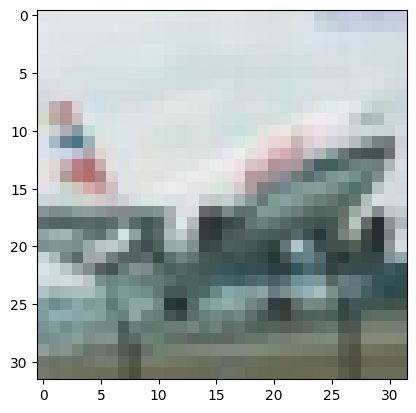

In [5]:
# 33번 이미지 한번 살펴보기
img, label = dataset[33]
plt.imshow(img.permute(1, 2, 0))

### 이미지 데이터
### 0단계 : cifar10를 통해 이미지 데이터 구조 이해하기

이미지 데이터는 픽셀이라고 부르는 단위안에 숫자로 구성된 데이터이다. cifar10 데이터는 가로32, 세로32의 크기를 갖는 이미지 데이터로 총 `32*32 = 1024` 개의 픽셀이 존재하는 데이터라고 볼 수 있다. 좌측은 실제 이미지 데이터를 숫자로 배열해 놓은것으로 가로32, 세로32의 행렬로 표현이 가능한 것을 확인할 수 있다.



<div align="center"><img src="https://github.com/int29/PDLP/blob/main/imgs/pytorch_01_01.png?raw=true" width="90%"></div>

In [6]:
# 실제 img는 그림과 같이 숫자로 된것을 확인할 수 있다.
img

tensor([[[0.8863, 0.8863, 0.8902,  ..., 0.7333, 0.7569, 0.7569],
         [0.8941, 0.8902, 0.8902,  ..., 0.7686, 0.7765, 0.7765],
         [0.8902, 0.8824, 0.8745,  ..., 0.8275, 0.8275, 0.8196],
         ...,
         [0.5608, 0.4980, 0.5216,  ..., 0.4392, 0.4235, 0.4157],
         [0.4353, 0.4157, 0.4314,  ..., 0.4000, 0.3961, 0.3961],
         [0.4667, 0.4392, 0.4471,  ..., 0.4196, 0.4196, 0.4235]],

        [[0.9020, 0.9020, 0.9059,  ..., 0.7765, 0.8000, 0.8039],
         [0.9098, 0.9059, 0.9059,  ..., 0.8078, 0.8118, 0.8196],
         [0.9059, 0.8980, 0.8941,  ..., 0.8667, 0.8667, 0.8667],
         ...,
         [0.6196, 0.5608, 0.5804,  ..., 0.4510, 0.4353, 0.4314],
         [0.4627, 0.4431, 0.4588,  ..., 0.4078, 0.4039, 0.4078],
         [0.4706, 0.4431, 0.4510,  ..., 0.4275, 0.4275, 0.4275]],

        [[0.9137, 0.9137, 0.9176,  ..., 0.8549, 0.8784, 0.8667],
         [0.9216, 0.9176, 0.9176,  ..., 0.8627, 0.8667, 0.8588],
         [0.9176, 0.9098, 0.9059,  ..., 0.8941, 0.8980, 0.

그렇다면 32x32로 표현된 데이터 속 숫자는 무엇을 의미할까? 바로 각 픽셀이 갖는 색상값을 의미한다. (사진 편집프로그램에서 자주 사용하는 기능처럼 이미지는 채널이라는 RGB 3원색의 조합값으로 모든 색상을 표현한다.)

<div align="center"><img src="https://github.com/int29/PDLP/blob/main/imgs/pytorch_01_00.png?raw=true" width="70%"></div>

1픽셀은 아래 그림처럼 3개의 채널 값을 갖고 32*32개의 픽셀로 구성된 이미지는 R(빨강의 정도), G(초록의 정도), B(파랑의 정도) 3개의 판으로 구성된 것이나 마찬가지인 셈이다. 이것을 수학적으로는 너비(W),높이(H),채널(C)의 `3차원 텐서`라고 부르며 이미지 데이터는 너비(W),높이(H),채널(C)의 3차원 데이터로 표현할 수 있다.

(텐서 외에 Array라고도 부르나, 딥러닝에서는 텐서라는 용어를 관습적으로 사용한다.)

In [7]:
# 이미지 데이터의 차원 살펴보기 
img.shape

torch.Size([3, 32, 32])

<div align="center"><img src="https://github.com/int29/PDLP/blob/main/imgs/pytorch_01_03.png?raw=true" width="80%"></div>

만약 각각의 판을 0으로 만들면 어떻게 되는지 확인해보자.

R채널을 제외하고 모두 0으로 만든다면 아래와 같이 붉은색만 존재하는 그림으로 표현되는 것을 확인할 수 있다.
<div align="center"><img src="https://github.com/int29/PDLP/blob/main/imgs/pytorch_01_06.png?raw=true" width="80%"></div>

G채널을 제외하고 모두 0으로 만든다면 아래와 같이 초록색만 존재하는 그림으로 표현되는 것을 확인할 수 있다.
<div align="center"><img src="https://github.com/int29/PDLP/blob/main/imgs/pytorch_01_05.png?raw=true" width="80%"></div>

B채널을 제외하고 모두 0으로 만든다면 아래와 같이 파란색만 존재하는 그림으로 표현되는 것을 확인할 수 있다.
<div align="center"><img src="https://github.com/int29/PDLP/blob/main/imgs/pytorch_01_04.png?raw=true" width="80%"></div>

In [8]:
# 각 채널을 분리하고, 나머지 채널을 0으로 설정
R_channel = img.clone()                    # img텐서 복사
R_channel[1, :, :] = 0  # G 채널을 0으로
R_channel[2, :, :] = 0  # B 채널을 0으로
R_channel = R_channel.permute(1, 2, 0)     # C, H, W 순서를 H, W, C로 변경 (시각화 때문에)

G_channel = img.clone()                    # img텐서 복사
G_channel[0, :, :] = 0  # R 채널을 0으로
G_channel[2, :, :] = 0  # B 채널을 0으로
G_channel = G_channel.permute(1, 2, 0)     # C, H, W 순서를 H, W, C로 변경 (시각화 때문에)

B_channel = img.clone()                    # img텐서 복사
B_channel[0, :, :] = 0  # R 채널을 0으로
B_channel[1, :, :] = 0  # G 채널을 0으로
B_channel = B_channel.permute(1, 2, 0)     # C, H, W 순서를 H, W, C로 변경 (시각화 때문에)

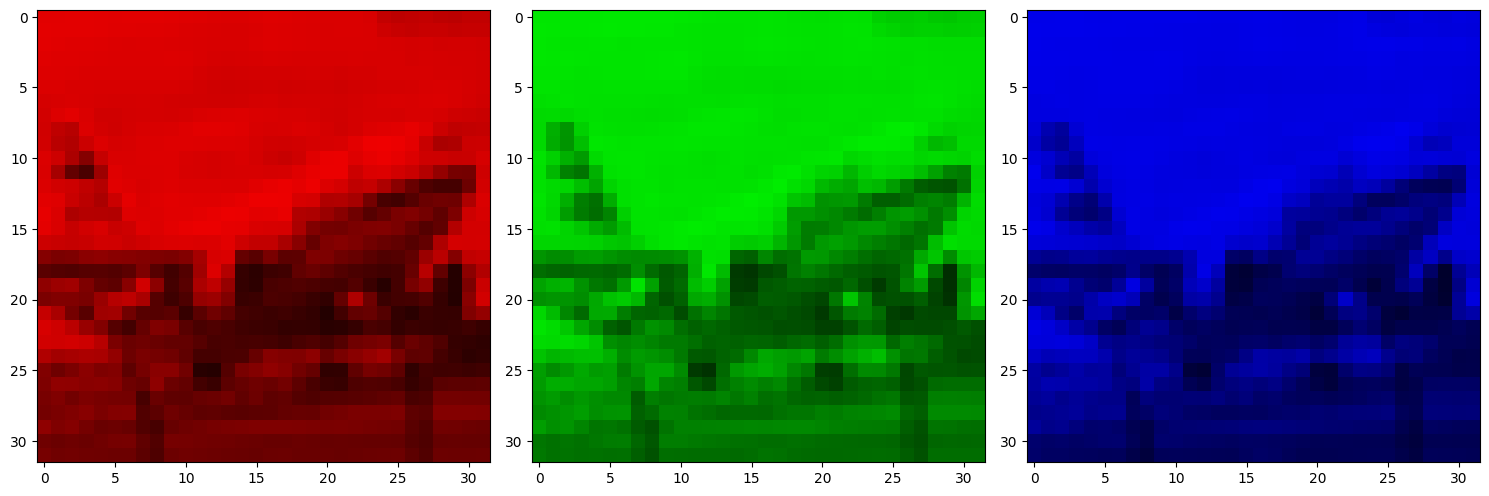

In [9]:
# 이미지 시각화
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 축 제거 3개의 사진을 표시할 수 있도록 subplot생성

axs[0].imshow(R_channel)  # 첫 번째 서브플롯에 R_channel 시각화
axs[1].imshow(G_channel)  # 두 번째 서브플롯에 G_channel 시각화
axs[2].imshow(B_channel)  # 세 번째 서브플롯에 B_channel 시각화

# 서브플롯의 레이아웃 조정
plt.tight_layout()
plt.show()

### 결론요약 : 이미지 데이터는
이미지는 가로(W), 높이(H), 채널(C)이라는 3차원의 어레이(Array)로 숫자표현이 가능하고 PyTorch,Tensorflow와 같은 딥러닝 프레임워크는 텐서(Tensor)라는 다차원 텐서 Array로 처리하고 계산함. 
<div align="center"><img src="https://github.com/int29/PDLP/blob/main/imgs/pytorch_01_07.png?raw=true" width="80%"></div>

이미지를 텐서라는 다차원 Array로 표현이 가능하다는 것은 이미지를 좌표 평면 상에 한 점으로 표시가 가능하다는 것
좌표 평면 상에 한 점으로 표시가 가능한 것은 계산이 가능하다는 것을 의미한다.

<div align="center"><img src="https://github.com/int29/PDLP/blob/main/imgs/pytorch_01_08.png?raw=true" width="80%"></div>

In [10]:
#<EOD>